<a href="https://colab.research.google.com/github/AsimZz/Univeristy-of-Khartoum-Graduation-Project/blob/master/RGB_Biocapacity_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RGB Models and Biocapacity Calculations


```
choose the model you would like to, Final model is the best one by 97% accuracy , for more informations : endomamoro9@gmail.com
```









### Initialization



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}
5
b'Pasture'
b'Pasture'


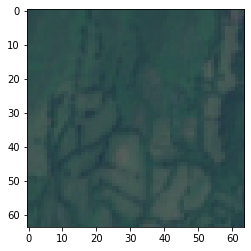

In [ ]:
### Data Prep

# - Download data from the Eurosat page: https://github.com/phelber/eurosat

# - Split the data into training (50%) and testing sets (50%), 
# stratified on class labels (equal percentage of each class type in train and test sets).

from google.colab import drive
drive.mount('/content/drive')

# processing and reading images
import zipfile
import requests
import io
from PIL import Image
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator


# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# plotting
import matplotlib.pyplot as plt

# modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd



# Download and read RGB EuroSAT images from URL


# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  # print(i)
  i += 1

del r # clear memory
del z 

# Get image labels

# Get labels in numpy array as strings
labs = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  labs[i] = label.split('/')[1]
  i += 1

# change them to integers in alphabetical order
label_names, yLabels = np.unique(labs, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T

# test that the labels and images read in properly
tmp = 18000
img = XImages[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
# plt.imshow(img);

# Balance the labels

# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
# smallest_class

# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]

# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)

yBal = yLabels[indBal]
XBal = XImages[indBal]

# print(yBal.shape)
# print(XBal.shape)

# first line uses balanced labels
# second line uses original imbalanced labels

# X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify = yLabels, train_size = 0.5, random_state=42)

# test that the labels and images are still matched up properly
tmp = 7000
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img);

# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

# convert class vectors to binary class matrices
from keras.utils import np_utils

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

## Model One





In [ ]:
### First Model

# - Convert each RBG image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)

# - Implement a first deep learning model `M1` using a fully connected network with a single dense layer. 

# - **Classification accuracy on the test data.** 22.0%

# This model does not include any spatial information (i.e., pixels don't have any information about neighboring pixels).

# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0],
                       X_train.shape[1],
                       X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0],
                      X_test.shape[1],
                      X_test.shape[2]])

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])
  X_test_BW[i] = rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0],
                                X_train_BW.shape[1] * X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0],
                              X_test_BW.shape[1] * X_test_BW.shape[2])

print("X_train_BW shape:" + str(X_train_BW.shape))
print("X_test_BW shape:" + str(X_test_BW.shape))
print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))

# Implement first deep learning model

# save model to here
model_file = '/content/drive/MyDrive/Temporal-Analysis-of-Regional-Sustainability-Using-CNNs-and-Satellite-Data /ds-rgb/Mfirst.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M1 = Sequential()
M1.add(Dense(num_classes, activation='softmax', input_shape=(4096,)))

M1.summary()



M1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

batch_size = 64
epochs = 100

M1.load_weights(model_file)


# history = M1.fit(X_train_BW, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     callbacks = callback_list,
#                     validation_data=(X_test_BW, y_test))

score = M1.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# y_test_true_tmp = np.argmax(y_test, axis = 1)
# label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, test_set):
  y_test_pred_tmp = np.argmax(model.predict(test_set), axis=-1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred_tmp = model.predict_classes(test_set)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df = pred_df.sort_values('y_true')

  return(pred_df)

M1_pred_df = eval_model_by_class(M1, X_test_BW)
M1_pred_df

# Model Two

In [ ]:
### Second Model

# - Implement a second deep learning model `M2` adding an additional dense layer to the previous model. 

# - **Classification accuracy on the test data.** 33.6%

model_file = '/content/drive/MyDrive/Temporal-Analysis-of-Regional-Sustainability-Using-CNNs-and-Satellite-Data /ds-rgb/M2.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M2 = Sequential()
M2.add(Dense(256, activation='relu', input_shape=(4096,)))
M2.add(Dense(num_classes, activation='softmax'))

M2.summary()

M2.load_weights(model_file)


M2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

# history = M2.fit(X_train_BW, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                  callbacks = callback_list,
#                     verbose=1,
#                     validation_data=(X_test_BW, y_test))

score = M2.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

M2_pred_df = eval_model_by_class(M2, X_test_BW)
M2_pred_df

# Model Three

In [ ]:
### Third Model

# - Implement a third deep learning model `M3` adding two additional dense layers as well as drop-out layers to the previous model. 

# - **Classification accuracy on the test data.** 25.8%
# - **Compare against previous models. Which model was the "best"? Why?** Of the first three models, `M2` was the best. It had a higher accuracy on the test data, and based on the plots showing training/testing loss and accuracy, it fit the data better than either Models M1 or M3, which both showed large fluctuations in the testing loss and accuracy.

model_file = '/content/drive/MyDrive/Temporal-Analysis-of-Regional-Sustainability-Using-CNNs-and-Satellite-Data /ds-rgb/M3.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M3 = Sequential()
M3.add(Dense(256, activation='relu', input_shape=(4096,)))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(num_classes, activation='softmax'))

M3.summary()

M3.load_weights(model_file)


M3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

# history = M3.fit(X_train_BW, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                  callbacks = callback_list,
#                     verbose=1,
#                     validation_data=(X_test_BW, y_test))

score = M3.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

M3_pred_df = eval_model_by_class(M3, X_test_BW)
M3_pred_df

# Model Four

In [ ]:
### Fourth Model

# - Using RGB images (without vectorizing them), implement a fourth model `M4` that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

# - **Classification accuracy on the test data.** 73.6%
# - **Compare against previous models. Which model was the "best"? Why?** Model `M4` is clearly the best so far, with a testing accuracy of 73.6%. The inclusion of the convolutional and maxpooling layers added a spatial component to the model, boosting the predictive power significantly. Based on the divergence of the training/testing loss and accuracy plots, the model started overfitting the training data after 10 or so epochs.

input_shape = X_train.shape[1:]

model_file = '/content/drive/MyDrive/Temporal-Analysis-of-Regional-Sustainability-Using-CNNs-and-Satellite-Data /ds-rgb/M4.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M4 = Sequential()
M4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
M4.add(Conv2D(64, (3, 3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2, 2)))
M4.add(Dropout(0.2))
M4.add(Flatten())
M4.add(Dense(256, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(num_classes, activation='softmax'))

M4.summary()

M4.load_weights(model_file)

M4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

# batch_size = 64
# epochs = 100
# history = M4.fit(X_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                  callbacks = callback_list,
#                     verbose=1,
#                     validation_data=(X_test, y_test))

score = M4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Interestingly, testing loss deterioates rapidly rapidly after about 10 epochs, but testing accuracy deteriorates more slowly.

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

M4_pred_df = eval_model_by_class(M4, X_test)
M4_pred_df

# Model Five

In [ ]:
# model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M5.h5'

# checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
#                                              monitor = 'val_loss',
#                                              save_best_only = True)

# callback_list = [checkpoint]
# M5 = Sequential()
# M5.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=(64,64,3)))
# M5.add(MaxPooling2D(pool_size=(2, 2)))
# M5.add(Conv2D(64, (3, 3), activation='relu'))
# M5.add(MaxPooling2D(pool_size=(2, 2)))
# M5.add(Conv2D(128, (3, 3), activation='relu'))
# M5.add(MaxPooling2D(pool_size=(2, 2)))
# M5.add(Conv2D(256, (3, 3), activation='relu'))
# M5.add(MaxPooling2D(pool_size=(2, 2)))
# M5.add(Flatten())
# M5.add(Dropout(0.5))
# M5.add(Dense(512, activation='relu'))
# # M5.add(Dropout(0.2))
# M5.add(Dense(num_classes, activation='softmax'))

# M5.summary()
# M5.compile(loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
#               metrics=['accuracy'])
# batch_size = 64
# epochs = 100
# # save model to here
# model_file = '/content/drive/MyDrive/Temporal-Analysis-of-Regional-Sustainability-Using-CNNs-and-Satellite-Data /ds-rgb/M1.h5'

# checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
#                                              monitor = 'val_loss',
#                                              save_best_only = True)

# callback_list = [checkpoint]
# M5.load_weights(model_file)
# history = M5.fit(X_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                  callbacks = callback_list,
#                     verbose=1,
#                     validation_data=(X_test, y_test))
# score = M5.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])


# Final Model

In [ ]:
import keras
model_file = '/content/drive/MyDrive/Graduation Project/ds-rgb/M8.h5'

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
import tensorflow as tf

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [ ]:

optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4)
lr_metric = get_lr_metric(optimizer)
M8 = Sequential()
input_shape = X_train.shape[1:]
conv_base = vgg16.VGG16(include_top=False,
            input_shape = input_shape)
M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

M8.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
batch_size = 64
epochs = 100
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = batch_size,
    seed = 42
)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size = batch_size,
    seed = 42
)



In [ ]:


M8.load_weights(model_file)

# history = M8.fit_generator(train_generator,
#                  steps_per_epoch = len(X_train) // 64,
#                  epochs = epochs,
#                  validation_data = test_generator,
#                  validation_steps = len(X_test) // 64,
#                  callbacks = callback_list)
# score = M8.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# M8_pred_df = eval_model_by_class(M8, X_test)
# M8_pred_df

# Predicting Khartoum State Labels





In [ ]:
!pip install image-slicer

{'AnnualCrop': 1,
 'Forest': 0,
 'HerbaceousVegetation': 17,
 'Highway': 0,
 'Industrial': 1475,
 'Pasture': 0,
 'PermanentCrop': 998,
 'Residential': 1,
 'River': 7,
 'SeaLake': 0}

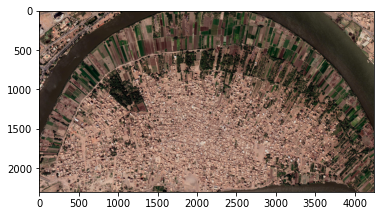

In [ ]:
from PIL import Image,ImageOps , ImageEnhance
import glob
import matplotlib.pyplot as plt
import matplotlib
import cv2
import numpy as np
from keras.preprocessing import image
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy import misc
import scipy.misc
import scipy
import image_slicer
from image_slicer import join
from PIL import Image
import imageio

#importing the full image
img=Image.open('/content/drive/MyDrive/Graduation Project/totilast.jpg')
#specifying the number of tiles 
num_tiles = 2500
#slicing the image 
tiles = image_slicer.slice('/content/drive/MyDrive/Graduation Project/totilast.jpg', num_tiles)
#adding the tiles into image list 
image_list = []
for tile in tiles:
    img = imageio.imread(tile.filename)
    image_list.append(img)
# work on the copy only
list1 = image_list
#making a prediction dict to save the predictions of each tile 
prediction = dict.fromkeys(range(0,2499 ))
pred_index = {}
#loop through the tiles 
AnnualCropindex = []
Forestindex = []
HerbaceousVegetationindex = []
Highwayindex = []
Industrialindex = []
Pastureindex = []
PermanentCropindex = []
Residentialindex = []
Riverindex = []
SeaLakeindex = []
for i in range(0,2499):
  #resizing so it can fit the model
  imgx = np.resize(list1[i],(64,64,3))
  img1 = image.img_to_array(imgx)
  img = np.expand_dims(img1, axis = 0)
  x =M8.predict(img)
  prediction[i] = x[0]
  index_max = np.argmax(prediction[i])
  pred_index[i] = index_max
  newlist = Image.fromarray(image_list[i])
  tiles[i].image = newlist
  if(pred_index[i] == 0):
    AnnualCropindex.append(i)
  if(pred_index[i] == 1):
    Forestindex.append(i)
  if(pred_index[i] == 2):
    HerbaceousVegetationindex.append(i)
  if(pred_index[i] == 3):
    Highwayindex.append(i)
  if(pred_index[i] == 4):
    Industrialindex.append(i)
  if(pred_index[i] == 5):
    Pastureindex.append(i)
  if(pred_index[i] == 6):
    PermanentCropindex.append(i)
  if(pred_index[i] == 7):
    Residentialindex.append(i)
  if(pred_index[i] == 8):
    Riverindex.append(i)
  if(pred_index[i] == 9):
    SeaLakeindex.append(i)

  #coloring each tile 
  # if index_max == 8:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2BGRA )
  # elif index_max == 7:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGBA )
  # elif index_max == 6:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2GRAY )
  # elif index_max == 5:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2BGR565 )
  # elif index_max == 4:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2XYZ )
  # elif index_max == 3:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2XYZ )
  # elif index_max == 2:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2YCrCb )
  # elif index_max == 1:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2HSV )
  # elif index_max == 9:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2HSV_FULL )
  # elif index_max == 0:
  #   list1[i] = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2HLS_FULL )


    # display(imgxx)
#merging tiles to one final image
# for i in range(0,2499):
#   newlist = Image.fromarray(image_list[i])
#   tiles[i].image = newlist
imgf = join(tiles)

plt.imshow(imgf)

#labels 
labels = {
  "AnnualCrop":0,
  "Forest" : 0,
    "HerbaceousVegetation" :0,
    "Highway":0,
    "Industrial":0,
    "Pasture":0,
    "PermanentCrop":0,
    "Residential":0,
    "River":0,
    "SeaLake":0
}
#the number of times a label found in the image 
labels["AnnualCrop"] = sum(value == 0 for value in pred_index.values())
labels["Forest"] = sum(value == 1 for value in pred_index.values())
labels["HerbaceousVegetation"] = sum(value == 2 for value in pred_index.values())
labels["Highway"] = sum(value == 3 for value in pred_index.values())
labels["Industrial"] = sum(value == 4 for value in pred_index.values())
labels["Pasture"] = sum(value == 5 for value in pred_index.values())
labels["PermanentCrop"] = sum(value == 6 for value in pred_index.values())
labels["Residential"] = sum(value == 7 for value in pred_index.values())
labels["River"] = sum(value == 8 for value in pred_index.values())
labels["SeaLake"] = sum(value == 9 for value in pred_index.values())
labels

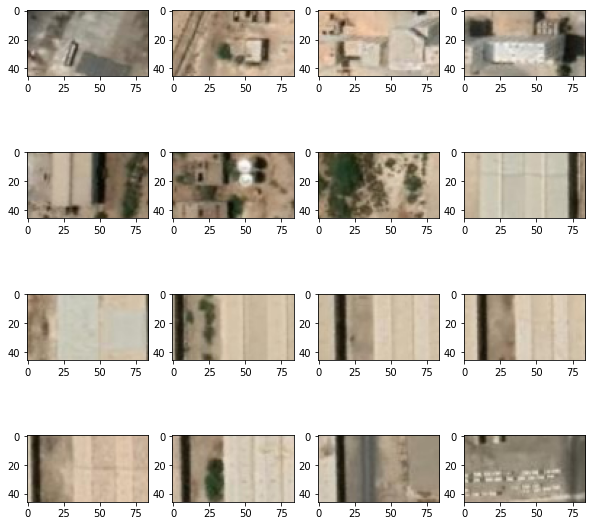

In [ ]:


# for i in range(0,2499):
#   if(pred_index[i] == 0):
#     AnnualCropindex.append(i)
#   if(pred_index[i] == 1):
#     Forestindex.append(i)
#   if(pred_index[i] == 2):
#     HerbaceousVegetationindex.append(i)
#   if(pred_index[i] == 3):
#     Highwayindex.append(i)
#   if(pred_index[i] == 4):
#     Industrialindex.append(i)
#   if(pred_index[i] == 5):
#     Pastureindex.append(i)
#   if(pred_index[i] == 6):
#     PermanentCropindex.append(i)
#   if(pred_index[i] == 7):
#     Residentialindex.append(i)
#   if(pred_index[i] == 8):
#     Riverindex.append(i)
#   if(pred_index[i] == 9):
#     SeaLakeindex.append(i)
indeustrialindex2 = Industrialindex[48:64]
fig = plt.figure(figsize=(10, 10))
rows = 4
columns = 4
q = 1
for i in indeustrialindex2:
  fig.add_subplot(rows, columns, q)
  q = q + 1 
  plt.imshow(tiles[i].image)



# Tuti Island Biocapacity Calculation

In [ ]:
#BioCapacity = sum(area_of_khartoum * Yeild_factor_of_Sudan * Equivalince_factor)
Area = 620 #for 2.94 zoom in google earth 
YF = {
    "Crop_Land":0.437252,
    "Forest_Land":0.439149,
    "Grazing_Land":1,
    "Marine_Fishing":1.47469,
    "Infrastructure":0.437252,
    "Inland_Fishing":1
}
EF = {
    "Crop_Land":2.49939691398113,
    "Forest_Land":1.26215878768974,
    "Grazing_Land":0.453121058342895,
    "Marine_Fishing":0.364490579331025,
    "Infrastructure":2.49939691398113,
    "Inland_Fishing":0.364490579331025
}
temp = {
    "Crop_Land":0,
    "Forest_Land":0,
    "Grazing_Land":0,
    "Marine_Fishing":0,
    "Infrastructure":0,
    "Inland_Fishing":0
}

temp['Crop_Land'] = labels['AnnualCrop'] + labels['PermanentCrop']
temp['Forest_Land'] = labels['Forest']
temp['Grazing_Land'] = labels['Pasture'] + labels['HerbaceousVegetation']
temp['Marine_Fishing'] = labels['River']
temp['Infrastructure'] = labels['Industrial'] + labels['Highway'] + labels['Residential']
temp['Inland_Fishing'] = labels['SeaLake']
bio = 0 
for i in EF:
    print(i,temp[i])
    percentage = temp[i] / num_tiles
    area = percentage * Area
    print(percentage,area)
    bio += area * YF[i] * EF[i] 
    print(bio)
print(bio/Area)

Crop_Land 999
0.3996 247.752
270.7598114168959
Forest_Land 0
0.0 0.0
270.7598114168959
Grazing_Land 17
0.0068 4.216
272.67016979886955
Marine_Fishing 7
0.0028 1.736
273.6032882220544
Infrastructure 1476
0.5904 366.048
673.6448113965673
Inland_Fishing 0
0.0 0.0
673.6448113965673
1.086523889349302
